In [1]:
#Imports
import os
import requests
import pandas as pd
import numpy as np
import pickle as pk
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import ccxt
import time
from dotenv import load_dotenv
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.cryptocurrencies import CryptoCurrencies
import csv
import joblib


Bad key "text.kerning_factor" on line 4 in
C:\Users\Josh Bond\Anaconda3\envs\dev\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
load_dotenv()

True

In [3]:
kraken_pub_key = os.getenv("KRAKEN_PUBLIC_KEY")
kraken_sec_key = os.getenv("KRAKEN_SECRET_KEY")
kraken = ccxt.kraken({"apiKey": kraken_pub_key, "secret": kraken_sec_key})

av_key = os.getenv("ALPHAVANTAGE_API_KEY")

In [4]:
# btc_historical = pd.read_csv('./Data/btc_raw.csv')
# btc_historical['Date'] = pd.to_datetime(btc_historical['Date'])
# btc_historical_df = btc_historical[['Date','Open','High','Low','Close','Volume']]
# btc_historical_df.rename(columns={'Date':'date','Open':'open','High':'high','Low':'low','Close':'close','Volume':'volume'}, inplace=True)
# btc_historical_df = btc_historical_df.sort_values(by='date')
# btc_historical_df.reset_index(inplace=True)
# btc_historical_df.drop(columns='index', inplace=True)

In [5]:
#Getting BTC data and setting columns and date
btc_historical = kraken.fetch_ohlcv("BTC/USD", '1d')
btc_historical_df = pd.DataFrame(
    btc_historical, 
    columns=['date','open','high','low','close','volume']
)
btc_historical_df['date'] = pd.to_datetime(btc_historical_df['date'], unit='ms')
btc_historical_df = btc_historical_df.sort_values(by='date')

In [6]:
if not os.path.exists('./Data'):
    os.makedirs('./Data')
if not os.path.exists('./Models'):
    os.makedirs('./Models')
if not os.path.exists('./Results'):
    os.makedirs('./Results')

In [7]:
#Defining functions
def compute_ema(df, window, colname):
    df[colname] = df['close'].ewm(halflife=window).mean()
    return(df)


def compute_rsi(df, window, colname):
    series = df['close']
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    # first value is sum of avg gains
    u[u.index[window - 1]] = np.mean(u[:window])
    u = u.drop(u.index[:(window - 1)])
    # first value is sum of avg losses
    d[d.index[window - 1]] = np.mean(d[:window])
    d = d.drop(d.index[:(window - 1)])
    rs = u.ewm(com=window - 1,ignore_na=False,
               min_periods=0,adjust=False).mean() / d.ewm(com=window - 1, ignore_na=False,
                                            min_periods=0,adjust=False).mean()
    df[colname] = 100 - 100 / (1 + rs)
    df[colname].fillna(df[colname].mean(), inplace=True)
    return(df)


def jwwma(values, n):

    # J. Welles Wilder's EMA 
    
    return values.ewm(alpha=1/n, min_periods=n, adjust=False).mean()

    
def atr(df, n=14):
    # The range of a day's trading is high-low. 
    dataframe = df.copy()
    high = df['high']
    low = df['low']
    close = df['close']
    dataframe['tr_1'] = abs(high - low)
    dataframe['tr_2'] = abs(high - close.shift())
    dataframe['tr_3'] = abs(low - close.shift())
    # The average true range can be found by finding the 
    tr = dataframe[['tr_1', 'tr_2', 'tr_3']].max(axis=1)
    atr = jwwma(tr, n)
    return atr


In [8]:
def compute_variables1(df):
    print("Let's compute predictive variables : ")
    df["date"] = pd.to_datetime(df["date"])
    df['bodysize'] = df['close'] - df['open']
    df['shadowsize'] = df['high'] - df['low']
    for window in [8, 13, 21, 34, 55, 89, 144, 377]:
        print(window)
        df = compute_ema(df, window, colname = 'ema_{}'.format(window))
        df = compute_rsi(df, window, colname = 'rsi_{}'.format(window))
        df["Min_{}".format(window)] = df["low"].rolling(window).min()
        df["Max_{}".format(window)] = df["high"].rolling(window).max()
        df["volume_{}".format(window)] = df["volume"].rolling(window).mean()
        df['percentChange_{}'.format(window)] = df['close'].pct_change(periods = window)
        df['RelativeSize_ema_{}'.format(window)] = df['close'] / df['ema_{}'.format(window)]
        df['Diff_{}'.format(window)] = df['close'].diff(window)
    df['ATR(14)'] = atr(df, n=14)

    # (a) Add modulo 10, 100, 1000, 500, 50 (these variables help identify psychological support and resistance levels)
    df["Modulo_10"] = df["close"].copy() % 10
    df["Modulo_100"] = df["close"].copy() % 100
    df["Modulo_1000"] = df["close"].copy() % 1000
    df["Modulo_500"] = df["close"].copy() % 500
    df["Modulo_50"] = df["close"].copy() % 50
    
    # (b) Add weekday and day of the month
    df["WeekDay"] = df["date"].dt.weekday
    df["Day"] = df["date"].dt.day
    df.dropna(inplace=True)
    return(df)

In [9]:
df = compute_variables1(btc_historical_df)

Let's compute predictive variables : 
8
13
21
34
55
89
144
377


In [10]:
df.to_csv('./Data/Datasetwithvariables.csv', index=False)

In [11]:
takeprofit = .12
stoploss = .05

In [12]:
def check_outcome(df, line, stoploss, takeprofit):
    '''0 means we reached stoploss
    1 means we reached takeprofit
    -1 means still in between'''
    price0 = df["close"].iloc[line]
    upper_lim = price0*(1+takeprofit)
    down_lim = price0*(1-stoploss)
    for i in range(line, df["close"].size):
        if df["low"].iloc[i] < down_lim :
            return(0)
        elif df["high"].iloc[i] > upper_lim :
            return(1)
    return(-1)

def compute_result(df, stoploss, takeprofit):
    df['result'] = 0
    for i in range(df["close"].size):
        if i%500 == 0:
            print(i, '/', df.shape[0])
        df['result'].iloc[i] = check_outcome(df, i, stoploss, takeprofit)
    return(df)

In [13]:
df = compute_result(df, stoploss, takeprofit)
df = df[df['result']>=0] # Only keep observations where we also have the result
df.to_csv('./Data/DatasetwithvariablesandY_SL{}_TP{}.csv'.format(stoploss, takeprofit), index = False)

0 / 343
C:\Users\Josh Bond\Anaconda3\envs\dev\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [14]:
df.head()

,date,open,high,low,close,volume,bodysize,shadowsize,ema_8,rsi_8,...,Diff_377,ATR(14),Modulo_10,Modulo_100,Modulo_1000,Modulo_500,Modulo_50,WeekDay,Day,result
377,2020-05-13,8818.1,9411.0,8808.1,9317.1,9472.110878,499.0,602.9,8585.621566,60.135889,...,3926.6,576.093673,7.1,17.1,317.1,317.1,17.1,2,13,0
378,2020-05-14,9317.1,9947.0,9256.9,9788.5,12966.020534,471.4,690.1,8685.455613,67.087895,...,4128.5,584.236982,8.5,88.5,788.5,288.5,38.5,3,14,0
379,2020-05-15,9788.5,9847.1,9128.0,9312.1,11082.915586,-476.4,719.1,8737.464563,55.840510,...,3548.6,593.870055,2.1,12.1,312.1,312.1,12.1,4,15,0
380,2020-05-16,9310.5,9590.0,9221.1,9386.0,4905.165281,75.5,368.9,8791.290382,57.115117,...,3666.7,577.800765,6.0,86.0,386.0,386.0,36.0,5,16,0
381,2020-05-17,9379.3,9888.0,9317.1,9673.0,6998.249638,293.7,570.9,8864.468716,61.985180,...,3985.6,577.307854,3.0,73.0,673.0,173.0,23.0,6,17,0


In [15]:
df['result'].value_counts()

0    199
1    143
Name: result, dtype: int64

In [16]:
# Define the trainset, validation set, testset
split1 = int(.65*len(df))

trainset = df[:split1]
val_test = df[split1:]

split2 = int(.5*len(val_test))

validation_set = val_test[:split2]
testset = val_test[split2:]

In [17]:
trainset.to_csv('./Data/Trainset_SL{}_TP{}.csv'.format(stoploss, takeprofit), index=False)
validation_set.to_csv('./Data/Validationset_SL{}_TP{}.csv'.format(stoploss, takeprofit), index=False)
testset.to_csv('./Data/Testset_SL{}_TP{}.csv'.format(stoploss, takeprofit), index=False)

C:\Users\Josh Bond\Anaconda3\envs\dev\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


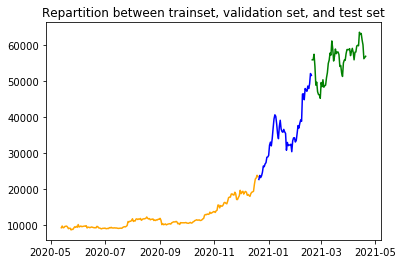

In [18]:
# Display the splitting
plt.plot(pd.to_datetime(trainset['date']), trainset['close'], c = 'orange')
plt.plot(pd.to_datetime(validation_set['date']), validation_set['close'], c = 'b')
plt.plot(pd.to_datetime(testset['date']), testset['close'], c = 'g')
plt.title('Repartition between trainset, validation set, and test set')
plt.show();

In [19]:
# (i) Scale the variables
scale_fct = StandardScaler()
scale_fct.fit(trainset.drop('date', 1).drop('result', 1))
joblib.dump(scale_fct, open('./Models/scaler.pkl','wb'))

In [20]:
# # (i) Scale the variables
# scale_fct = StandardScaler()
# scale_fct.fit(trainset.drop('date', 1).drop('result', 1))
# pk.dump(scale_fct, open('./Models/scaler.pkl','wb'))

In [21]:
# (ii) Apply PCA
pca = PCA(n_components=trainset.shape[1] - 2) # remove the result and the date
pca.fit(scale_fct.transform(trainset.drop('date', 1).drop('result', 1)))
joblib.dump(pca, open('./Models/pca.pkl', 'wb'))

In [22]:
# # (ii) Apply PCA
# pca = PCA(n_components=trainset.shape[1] - 2) # remove the result and the date
# pca.fit(scale_fct.transform(trainset.drop('date', 1).drop('result', 1)))
# pk.dump(pca, open('./Models/pca.pkl',"wb"))

In [23]:
# (iii) Scale PCA components (this accelerates training process in Deep Learning)
pca_scaler = StandardScaler()
pca_scaler.fit(pca.transform(scale_fct.transform(trainset.drop('date', 1).drop('result', 1))))
joblib.dump(pca_scaler, open('./Models/pca_scaler.pkl','wb'))

In [24]:
# # (iii) Scale PCA components (this accelerates training process in Deep Learning)
# pca_scaler = StandardScaler()
# pca_scaler.fit(pca.transform(scale_fct.transform(trainset.drop('date', 1).drop('result', 1))))
# pk.dump(pca_scaler, open('./Models/pca_scaler.pkl','wb'))

In [25]:
# (iv) Save ready-to-use versions (i.e. datasets after applying scalers and PCA)
trainset_final = pd.DataFrame(pca_scaler.transform(pca.transform(scale_fct.transform(trainset.drop('date', 1).drop('result', 1)))))
validation_set_final = pd.DataFrame(pca_scaler.transform(pca.transform(scale_fct.transform(validation_set.drop('date', 1).drop('result', 1)))))
testset_final = pd.DataFrame(pca_scaler.transform(pca.transform(scale_fct.transform(testset.drop('date', 1).drop('result', 1)))))

In [26]:
trainset_final.to_csv('./Data/Trainset_final_SL{}_TP{}.csv'.format(stoploss, takeprofit), index = False)
validation_set_final.to_csv('./Data/Validationset_final_SL{}_TP{}.csv'.format(stoploss, takeprofit), index = False)
testset_final.to_csv('./Data/Testset_final_SL{}_TP{}.csv'.format(stoploss, takeprofit), index = False)

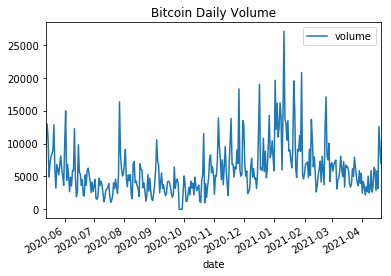

In [27]:
vol_fig = df.plot(
    x='date',
    y='volume',
    title='Bitcoin Daily Volume'
)

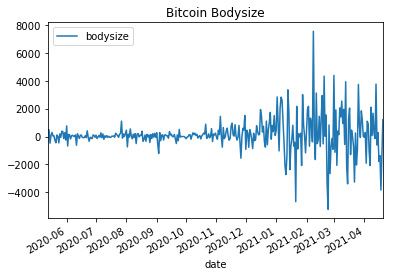

In [28]:
body_fig = df.plot(
    x='date',
    y='bodysize',
    title='Bitcoin Bodysize'
)

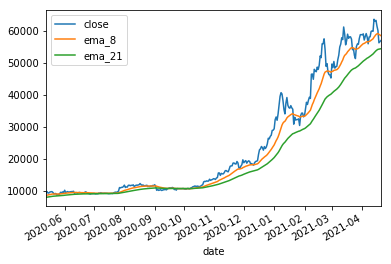

In [29]:
ema_fig = df.plot(
    x= 'date',
    y =['close','ema_8','ema_21']
)

In [ ]:
df.head()

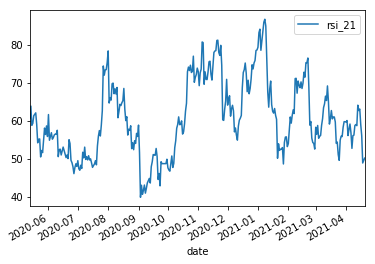

In [30]:
rsi_fig = df.plot(
    x= 'date',
    y =['rsi_21']
)